In [ ]:
# Homework 3

## Loading Data and Imporating Libray
Here I load all of the necceasry data and libraries I will be using for this Lab.

In [702]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
import re

In [614]:
cellphone_data = pd.read_csv("cell_phones_total.csv")
population_data = pd.read_csv("pop_data.csv")
country_mapping = pd.read_csv("country_data.csv")



# Joining Data

Function from HW3 to clean and fill cell_phones_total.csv

In [616]:

df_na = cellphone_data.replace("", np.nan)
df_filled = df_na.ffill().bfill()

def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.strip().lower()
        if 'k' in value:
            return float(value.replace('k', '')) * 1e3
        elif 'm' in value:
            return float(value.replace('m', '')) * 1e6
        elif 'b' in value:
            return float(value.replace('b', '')) * 1e9
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan


df_final = df_filled.copy()
for col in df_final.columns[1:]:
    df_final[col] = df_final[col].apply(convert_to_numeric)

df_final = df_final.fillna(0.0)

df_final.head(5)

,iso-3,1960,1965,1966,1967,1968,1969,1970,1971,1972,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,132000.0,13800000.0,135000.0,139000.0,140000.0,141000.0,21600000.0,23900000.0,22000000.0,22600000.0
1,AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10200000.0,13800000.0,15300000.0,16800000.0,18400000.0,19700000.0,21600000.0,23900000.0,22000000.0,22600000.0
2,AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9400000.0,12100000.0,12800000.0,13300000.0,14100000.0,13900000.0,13000000.0,13300000.0,13300000.0,14800000.0
3,ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2690000.0,3100000.0,3500000.0,3690000.0,3360000.0,3400000.0,3370000.0,3630000.0,2710000.0,2630000.0
4,AND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65500.0,65000.0,63900.0,63900.0,66200.0,71300.0,76100.0,80300.0,82600.0,87900.0


Now we will deal with pop_data.csv. There is a row: INX which has missing data. This row will be removed. Then we will drop the 2020 coloum from the dataframe. This is done since when we compare with cell_phones_total.csv we want the length of the coloums to be the same. We extract the years and put it into a vector. We then reshape the dataset in the proper format. This is dont with the pandas melt function. We format it into a table with coloums iso-3, year and population. We then make sure that the year and population cekks are numeric, incase some of them are strings.

In [618]:


population_data = population_data[population_data['iso-3'] != 'INX']
population_data = population_data.drop(columns=['2020'])


year_columns = [str(year) for year in range(1960, 2020)]  
population_data_long = pd.melt(population_data, id_vars=['iso-3'], value_vars=year_columns, var_name='year', value_name='population')

population_data_long['year'] = pd.to_numeric(population_data_long['year'], errors='coerce')
population_data_long['population'] = pd.to_numeric(population_data_long['population'], errors='coerce')

population_data_long.head()

,iso-3,year,population
0,ABW,1960,54608.0
1,AFE,1960,130692579.0
2,AFG,1960,8622466.0
3,AFW,1960,97256290.0
4,AGO,1960,5357195.0


We now do the same things for the cell_phones_total.csv data. Since this data is already cleaned and filled we only need to peform the reshaping in the same manner as before.

In [620]:
df_long = pd.melt(df_final, id_vars=['iso-3'], var_name='year', value_name='n_cellphones')

df_long.head()

,iso-3,year,n_cellphones
0,ABW,1960,0.0
1,AFG,1960,0.0
2,AGO,1960,0.0
3,ALB,1960,0.0
4,AND,1960,0.0


Now i needed to Convert the year column in both DataFrames to int64 so that we can add them together.

In [622]:
df_long['year'] = df_long['year'].astype(int)
population_data_long['year'] = population_data_long['year'].astype(int)

Now we merge the cellphone data and population data based of on iso-3 and year. We also calculate the cellhpone per capital by dividing the amount of cellphones and the population. We then merge all of this data into one table show it.

In [630]:
df_final_merged = pd.merge(df_long, population_data_long, on=['iso-3', 'year'], how='left')

df_final_merged['cellphones_per_capita'] = df_final_merged['n_cellphones'] / df_final_merged['population']

df_final_merged.head()

,iso-3,year,n_cellphones,population,cellphones_per_capita
0,ABW,1960,0.0,54608.0,0.0
1,AFG,1960,0.0,8622466.0,0.0
2,AGO,1960,0.0,5357195.0,0.0
3,ALB,1960,0.0,1608800.0,0.0
4,AND,1960,0.0,9443.0,0.0


Now we want to create a mapping between iso-3 and country name which is found in country_data.csv. We do this by matching the iso-3 codes from df_final_merged with the alpha-3 codes in country_mapping to add the corresponding country names (name column) to df_final_merged. After merging, we remove the extra alpha-3 column.

In [634]:
df_final_merged_with_names = pd.merge(df_final_merged, country_mapping[['alpha-3', 'name']], left_on='iso-3', right_on='alpha-3', how='left')

df_final_merged_with_names = df_final_merged_with_names.drop(columns=['alpha-3'])

df_final_merged_with_names.head()

,iso-3,year,n_cellphones,population,cellphones_per_capita,name
0,ABW,1960,0.0,54608.0,0.0,Aruba
1,AFG,1960,0.0,8622466.0,0.0,Afghanistan
2,AGO,1960,0.0,5357195.0,0.0,Angola
3,ALB,1960,0.0,1608800.0,0.0,Albania
4,AND,1960,0.0,9443.0,0.0,Andorra


The table shown in the homework are the countries with the highest number of cellphones per capita in 2019. SO lets filter the data for the year 2019 and find the countries the have the top five highest number of cell phones per capita in 2019. Since i got some numbers that were very high for exempel Palau with 9321.277071 phones per capita, I filtered the data so that it was for countries with cellphones per capita less than 4. This would make it more realistic since in my opinion, 4 cellphones per capita is the highestnumber which i beleive is still beleivable. This does though highlight potential problems with the data, showcasing that it might not be accurate or problems with the filling/cleaning of data.

In [654]:
df_2019 = df_final_merged_with_names[df_final_merged_with_names['year'] == 2019]
df_2019_under_5 = df_2019[df_2019['cellphones_per_capita'] < 4]
top_5_2019_under_5 = df_2019_under_5.sort_values(by='cellphones_per_capita', ascending=False).head(5)

print(top_5_2019_under_5[['iso-3', 'name', 'cellphones_per_capita']])



      iso-3       name  cellphones_per_capita
11794   BMU    Bermuda               3.989923
11903   MUS  Mauritius               3.720423
11886   MAC      Macao               3.119100
11851   HKG  Hong Kong               2.863650
11860   IRQ       Iraq               2.839028


Now we want to display a table in the same way as in the homework guide. We create a table with the coutries are the ones with highest number of cell phones per capita in 2019, and also add thier cellphones per capita for years 2018,2017,2016,2015

In [656]:

countries = ['Bermuda', 'Mauritius', 'Macao', 'Hong Kong', 'Iraq']

df_filtered = df_final_merged_with_names[(df_final_merged_with_names['year'].between(2015, 2019)) & 
                                         (df_final_merged_with_names['name'].isin(countries))]

df_pivot = df_filtered.pivot_table(index='year', columns='name', values='cellphones_per_capita')

df_pivot


name,Bermuda,Hong Kong,Iraq,Macao,Mauritius
year,,,,,
2015,0.582492,2.290401,0.889882,3.088231,1.393641
2016,0.989869,2.398931,0.863095,3.143510,1.432249
2017,1.017644,2.488773,0.842984,3.210102,1.454675
2018,3.848681,2.670209,0.899221,3.348741,1.517095
2019,3.989923,2.863650,2.839028,3.119100,3.720423


Now we want to create a plot that illustrates the growth rate of the countries in the table above over the last 10 years. We filter the data for the years 2010 to 2019. We calculate the growth rate for each country, more specifically the percentage change between 2010 and 2019. We the plot the growth rate for each country and we can see that mauritius had the highes groth rate with around 275%!

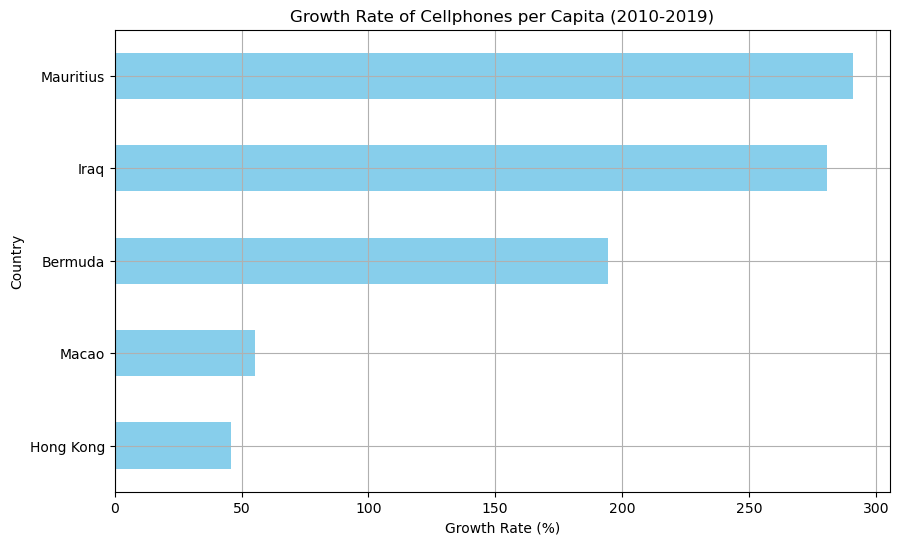

In [664]:
df_filtered_10_years = df_final_merged_with_names[(df_final_merged_with_names['year'].between(2010, 2019)) & 
(df_final_merged_with_names['name'].isin(countries))]

df_pivot_10_years = df_filtered_10_years.pivot_table(index='year', columns='name', values='cellphones_per_capita')

growth_rate = (df_pivot_10_years.loc[2019] - df_pivot_10_years.loc[2010]) / df_pivot_10_years.loc[2010] * 100

plt.figure(figsize=(10, 6))
growth_rate.sort_values().plot(kind='barh', color='skyblue')
plt.title('Growth Rate of Cellphones per Capita (2010-2019)')
plt.xlabel('Growth Rate (%)')
plt.ylabel('Country')
plt.grid(True)
plt.show()



# SQL

- Retrieve the usernames of all users who have performed the "signup" action.

In [696]:
conn = sqlite3.connect('user_actions.db')


query_signup = "SELECT DISTINCT username FROM user_actions WHERE action = 'signup';"
df_signup = pd.read_sql_query(query_signup, conn)
df_signup




,username
0,user34
1,user28
2,user1
3,user24
4,user15
5,user20
6,user18
7,user25
8,user3
9,user9


- Find the total number of log entries for each user. Display the user_id, username, and the count of log entries.

In [698]:
query_log_count = """
SELECT user_id, username, COUNT(*) AS log_count
FROM user_actions
GROUP BY user_id, username;
"""
df_log_count = pd.read_sql_query(query_log_count, conn)
df_log_count



,user_id,username,log_count
0,1,user1,104
1,2,user2,149
2,3,user3,108
3,4,user4,436
4,5,user5,192
5,6,user6,457
6,7,user7,362
7,8,user8,329
8,9,user9,118
9,10,user10,170


In [ ]:
- Identify users who have both logged in (action = 'login') and signed up (action = 'signup') on the same day. Display the user_id and username.

In [700]:
query_same_day = """
SELECT DISTINCT a.user_id, a.username
FROM user_actions a
JOIN user_actions b
    ON a.user_id = b.user_id
    AND DATE(a.timestamp) = DATE(b.timestamp)
WHERE a.action = 'login'
  AND b.action = 'signup';
"""
df_same_day = pd.read_sql_query(query_same_day, conn)
print(df_same_day)

conn.close()

   user_id username
0        8    user8
1       12   user12
2       30   user30
3        7    user7
4       22   user22
5        5    user5
6        2    user2
7       32   user32


# Regex

- Write a regular expression to extract all hashtags from a given comment. For example, applying the regex to comment 1 should return ["#programming", "#tips"].

In [704]:
comment = "when #programming i ask for #tips."

hashtags = re.findall(r'#\w+', comment)

print(hashtags)  


['#programming', '#tips']


In [706]:
comment = "#programming with #python is fun. "

# Check if both hashtags are present
match = re.search(r'(?=.*#programming)(?=.*#python)', comment)

if match:
    print("Match")
else:
    print("No match")


Match
